In [ ]:
#IMPORT ALL THE NECESSARY PACKAGES:

In [1]:
#DATA MANIPULATION 
import pandas as pd
import numpy as np

#VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

#DATE AND TIME
from datetime import datetime

#CLUSTURING 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#IGNORE WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [2]:
#LOAD THE DATA 
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
                 #on_bad_lines='skip',
                 #quoting=3,           # QUOTE_NONE - don't use quotes for field detection
                # engine='python')    # Load the entire file into memory

#PREVIEW
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [12]:
#DATA CLEANING:

In [3]:
#REMOVE NULLS
df.dropna(inplace=True)

#Filter only UK customers
df = df[df['Country'] == 'United Kingdom']

#REMOVE CANCELLED ORDERS
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

#REMOVE NEGATIVE QUANTITIES AND PRICES
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

#CONVERT INVOICEDATE TO DATETIME
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#FEARTURE ENGINNERING - RFM ANALYSIS:

In [4]:
#SET REFERENCE DATE FROM RECENCY
reference_date = df['InvoiceDate'].max()

#ADD TOTALPRICE COLUMN IF NOT PRESENT
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

#CREATE RFM TABLE
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceDate': 'nunique',
    'TotalPrice': lambda x: np.sum(x) 
        if 'TotalPrice' in df.columns 
    else 0
})

#RFM WITH TOTALRPICE
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

#RENAME COLUMNS
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,1,11,4196.01
12748.0,0,209,33719.73
12749.0,3,5,4090.88
12820.0,2,4,942.34


In [32]:
#APPLY K-MEANS CLUSTERING:

In [5]:
#SCALE THE DATA
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

#FIT K-MEANS
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

#ASSIGN CLUSTER
rfm['Cluster'] = kmeans.labels_

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,2
12747.0,1,11,4196.01,3
12748.0,0,209,33719.73,2
12749.0,3,5,4090.88,1
12820.0,2,4,942.34,1


In [34]:
#VISUALIZE SEGMENTS:

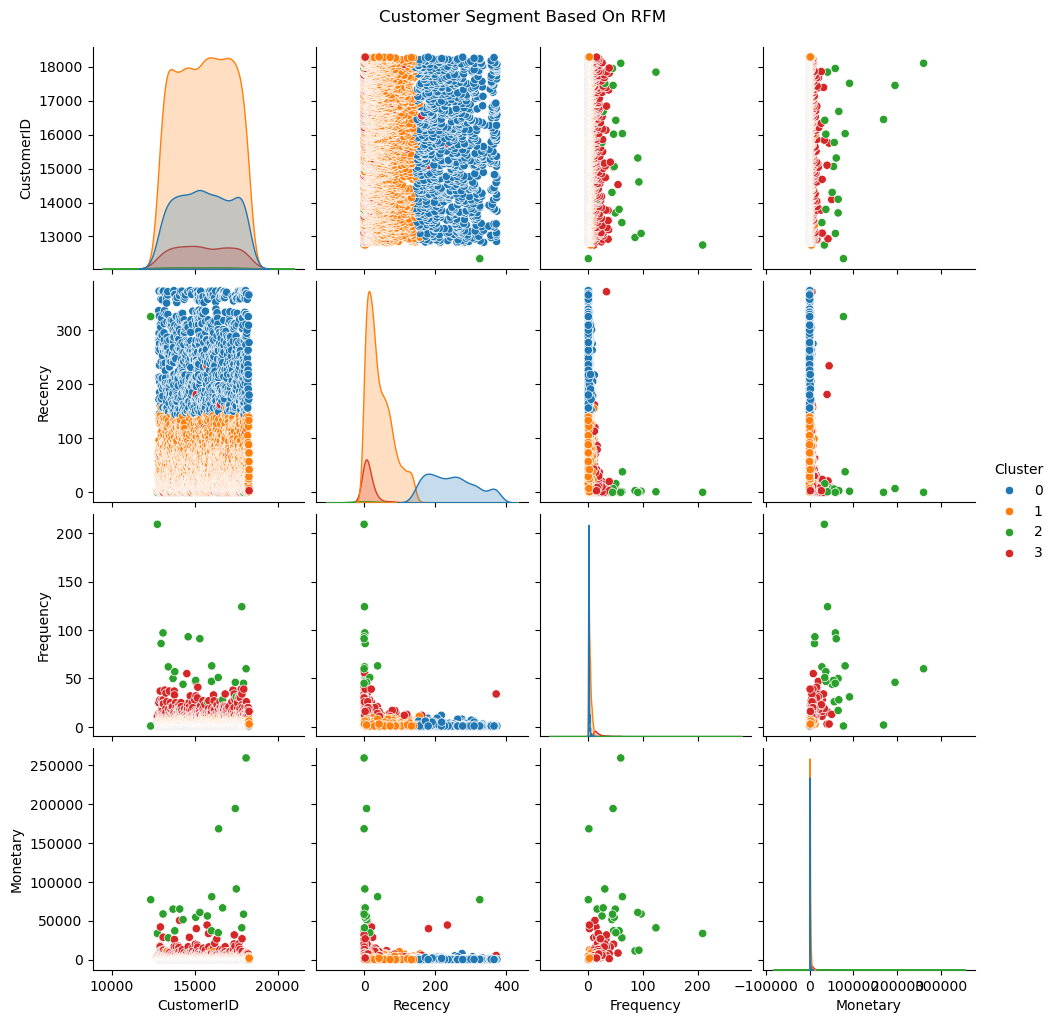

In [8]:
sns.pairplot(rfm.reset_index(), hue='Cluster', palette='tab10')
plt.suptitle('Customer Segment Based On RFM', y=1.02)
plt.show()

🟢 Cluster 2 – High-Value Loyal Customers
In the Monetary plots, green dots are the highest by far. Some customers spent up to 200,000+.

They also appear with high Frequency (buy often) and low Recency (they bought recently).

Conclusion: These are the most valuable, most loyal customers. Keep them happy!

Recommendation: Offer VIP loyalty programs, early access deals, or personalized appreciation emails.

🟠 Cluster 1 – Recent but Inactive Customers
In the Recency distribution (second row), orange is clustered near the bottom, meaning they bought recently.

However, in the Monetary and Frequency plots, they are very low.

Conclusion: These may be new customers or people who tried the store recently but haven’t yet come back or spent much.

Recommendation: Send welcome messages, special deals, and onboarding info to turn them into loyal buyers.


🔴 Cluster 3 – Low Value, Possibly One-Time Buyers
In Recency, red dots are a bit more spread out — some recent, some older.

Frequency is very low — these customers rarely come back.

Monetary is also low.

Conclusion: This group likely includes one-time or disengaged buyers.

Recommendation: Re-engage with reminders, “we miss you” emails, or ask for feedback.


🔵 Cluster 0 – Moderately Active Group
Appears in the middle range across Recency, Frequency, and Spend.

Not as high as Cluster 2, but not inactive like Cluster 3.

Conclusion: This is a stable group, maybe regular but lower spenders.

Recommendation: Consider encouraging larger purchases through bundling, cross-sells, or limited-time offers.

In [20]:
rfm.reset_index().to_csv('rfm_segmented_utf8.csv', index=False, encoding='utf-8')